## Credit Card Fraud Detection

To build a classification model based on credit card transaction data to predict which transaction records are anomalous and which are normal.

### Purpose：
Classify the dataset into normal transaction data and anomalous transaction data, and predict the test data by assigning them with 0 or 1 labels.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings  
warnings.filterwarnings('ignore')

In [2]:
# read data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data = pd.read_csv('/content/drive/MyDrive/COEN240/Credit_Card_Fraud/creditcard.csv')
data.head()

Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data：


0    284315
1       492
Name: Class, dtype: int64


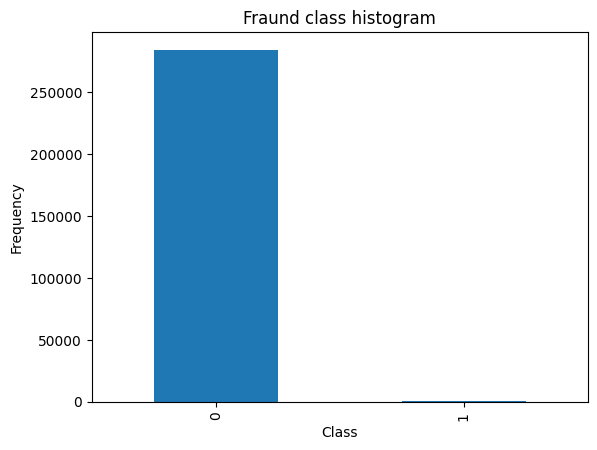

In [3]:
# # plot the data for 0 class and 1 class
count_classes = pd.value_counts(data['Class'], sort=True).sort_index() 
count_classes.plot(kind='bar')  
plt.title("Fraund class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
print(count_classes)

### Standardization 


In [4]:
from sklearn.preprocessing import StandardScaler

# X = (x-μ)/σ,
# fit_transform(data['Amount']) find μ and σ for data['Amount']
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Time', 'Amount'], axis=1)  # drop column Time
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### Regularization 


In [5]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def kfold_regularization(X, y):

  # Perform k-fold cross-validation
  k = 5  # Number of folds
  kf = KFold(n_splits=k, shuffle=True, random_state=42)

  # Define different regularization parameters to try
  c_params = [0.01,0.1,1,10, 100, 1000,10000, 100000]
   # store result
  results_table = pd.DataFrame(index = range(len(c_params),2), columns = ['c_params','Mean recall score'])
  results_table['c_params'] = c_params
  j = 0
  # Iterate over each regularization parameter
  for c_param in c_params:
      print("C parameter:", c_param)
      print("--------------------")

      # Initialize lists to store evaluation metrics
      accuracy_scores = []
      recall_scores = []
      

      # Iterate over each fold
      for train_index, test_index in kf.split(X):
          # Split the data into training and testing sets for the fold
          X_train, X_test = X.iloc[train_index], X.iloc[test_index]
          y_train, y_test = y.iloc[train_index], y.iloc[test_index]

          # Create a LogisticRegression classifier with regularization
          lr = LogisticRegression(C = c_param)

          # Train the model
          lr.fit(X_train, y_train)

          # Make predictions on the testing set
          y_pred = lr.predict(X_test)

          # Evaluate the model
          accuracy = accuracy_score(y_test, y_pred)
          recall = recall_score(y_test, y_pred)
          

          # Append the evaluation scores to the lists
          accuracy_scores.append(accuracy)
          recall_scores.append(recall)

      # Calculate the average evaluation scores across all folds
      average_accuracy = np.mean(accuracy_scores)
      average_recall = np.mean(recall_scores)
      results_table.loc[j,'Mean recall score'] = average_recall
      j += 1

      
      # Print the average evaluation scores
      print("Average Accuracy:", average_accuracy)
      print("Average Recall:", average_recall)
      print()
  print(results_table)
  best_reg = results_table.loc[results_table['Mean recall score'].astype('float32').idxmax()]['c_params']
  print('best c parameters  = ', best_reg)
  return best_reg


### Plot confusion Matrix 

In [6]:
import itertools
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Threshhold

In [7]:
from sklearn.metrics import confusion_matrix
#finding the best threshhold
def best_thresh(Xtrain, ytrain, Xtest, ytest, best_c_param):
# using the best regularization parameters
  lr = LogisticRegression(C = best_c_param)

  lr.fit(Xtrain, ytrain.values.ravel())

  # get the predict probability
  y_pred_undersample_proba = np.array(lr.predict_proba(Xtest.values))

  thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  plt.figure(figsize=(8,8))
  j = 1

  for i in thresholds:
      y_test_predictions_high_recall = y_pred_undersample_proba[:, 1] > i
      cnf_matrix = confusion_matrix(ytest,y_test_predictions_high_recall)
      np.set_printoptions(precision=2)

      print("thresholds: ",i,"Recall:", '{0:.2f}'.format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
          ,"Accuracy:", '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])))
      class_names = [0,1]
      plt.subplot(3, 3, j)
      j += 1
      plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Confusion matrix')


### Original Sample

In [8]:
# divide data to X and y
X = data.loc[:,data.columns != "Class"]  # features
y = data.loc[:,data.columns == "Class"]  # label

# divide Data to train data 0.7 and test data 0.3
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("Orginal Train Data Number:", len(X_train))
print("Orginal Test Data Number:", len(X_test))
print("Orginal Total Data Number:", len(X_train)+len(X_test))

Orginal Train Data Number: 199364
Orginal Test Data Number: 85443
Orginal Total Data Number: 284807


In [9]:
best_c_org = kfold_regularization(X, y)

C parameter: 0.01
--------------------
Average Accuracy: 0.9991538127849685
Average Recall: 0.5910145716071902

C parameter: 0.1
--------------------
Average Accuracy: 0.9991608350103117
Average Recall: 0.607492765769422

C parameter: 1
--------------------
Average Accuracy: 0.9991748795842794
Average Recall: 0.6195036686025416

C parameter: 10
--------------------
Average Accuracy: 0.9991748795842794
Average Recall: 0.6195036686025416

C parameter: 100
--------------------
Average Accuracy: 0.9991748795842794
Average Recall: 0.6195036686025416

C parameter: 1000
--------------------
Average Accuracy: 0.9991748795842794
Average Recall: 0.6195036686025416

C parameter: 10000
--------------------
Average Accuracy: 0.9991748795842794
Average Recall: 0.6195036686025416

C parameter: 100000
--------------------
Average Accuracy: 0.9991748795842794
Average Recall: 0.6195036686025416

    c_params Mean recall score
0       0.01          0.591015
1       0.10          0.607493
2       1.00    

thresholds:  0.1 Recall: 0.78 Accuracy: 0.844
thresholds:  0.2 Recall: 0.73 Accuracy: 0.837
thresholds:  0.3 Recall: 0.69 Accuracy: 0.863
thresholds:  0.4 Recall: 0.65 Accuracy: 0.864
thresholds:  0.5 Recall: 0.62 Accuracy: 0.883
thresholds:  0.6 Recall: 0.59 Accuracy: 0.888
thresholds:  0.7 Recall: 0.56 Accuracy: 0.882
thresholds:  0.8 Recall: 0.52 Accuracy: 0.875
thresholds:  0.9 Recall: 0.49 Accuracy: 0.867


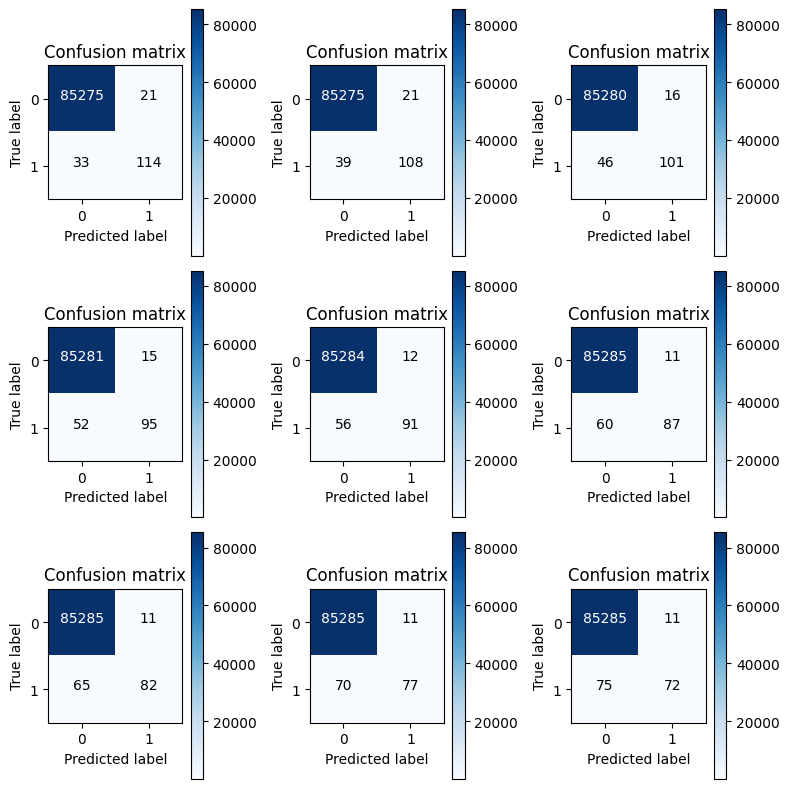

In [10]:
best_thresh(X_train,  y_train, X_test, y_test, best_c_org)

### Undersampling

In [11]:
# Fraud data and indices
number_records_fraud=len(data[data.Class==1])
fraud_indices=np.array(data[data.Class==1].index)

# normal indices
normal_indices=data[data.Class==0].index
 
# random choosing normal samples with indices

random_normal_indices=np.random.choice(normal_indices, number_records_fraud,replace=False) 
random_normal_indices=np.array(random_normal_indices)

# combine noral and fraud indices
under_sample_indices=np.concatenate([fraud_indices,random_normal_indices])

# get undersampling sample datas
under_sample_data=data.iloc[under_sample_indices,:]

# divide undersampling sample datas to X_under_sample, Y_under_sample
X_under_sample=under_sample_data.iloc[:,under_sample_data.columns != "Class"]
Y_under_sample=under_sample_data.iloc[:,under_sample_data.columns == "Class"]

print("Normal data percentage: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Fraud data percentage: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total undersampling Number: ", len(under_sample_data))

Normal data percentage:  0.5
Fraud data percentage:  0.5
Total undersampling Number:  984


In [12]:
# divide undersampling Data to train data 0.7 and test data 0.3
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample \
= train_test_split(X_under_sample ,Y_under_sample ,test_size = 0.3,random_state = 0)

print("Undersampling Train Data Number: ", len(X_train_undersample))
print("Undersampling Test Data Number: ", len(X_test_undersample))
print("Undersampling Total Data Number: ", len(X_train_undersample)+len(X_test_undersample))

Undersampling Train Data Number:  688
Undersampling Test Data Number:  296
Undersampling Total Data Number:  984


In [13]:
best_c_under = kfold_regularization(X_train_undersample, y_train_undersample)

C parameter: 0.01
--------------------
Average Accuracy: 0.9346133502591769
Average Recall: 0.8758314214093005

C parameter: 0.1
--------------------
Average Accuracy: 0.9375013223315349
Average Recall: 0.8982934086418968

C parameter: 1
--------------------
Average Accuracy: 0.9389717549984132
Average Recall: 0.9156229420262146

C parameter: 10
--------------------
Average Accuracy: 0.9316724849254205
Average Recall: 0.912557490493489

C parameter: 100
--------------------
Average Accuracy: 0.9273246588384639
Average Recall: 0.9153743919019395

C parameter: 1000
--------------------
Average Accuracy: 0.9316724849254205
Average Recall: 0.9183155683725278

C parameter: 10000
--------------------
Average Accuracy: 0.9316724849254205
Average Recall: 0.9214405683725279

C parameter: 100000
--------------------
Average Accuracy: 0.9331217602877393
Average Recall: 0.9214405683725279

    c_params Mean recall score
0       0.01          0.875831
1       0.10          0.898293
2       1.00    

thresholds:  0.1 Recall: 0.95 Accuracy: 0.833
thresholds:  0.2 Recall: 0.94 Accuracy: 0.896
thresholds:  0.3 Recall: 0.93 Accuracy: 0.919
thresholds:  0.4 Recall: 0.93 Accuracy: 0.932
thresholds:  0.5 Recall: 0.93 Accuracy: 0.958
thresholds:  0.6 Recall: 0.91 Accuracy: 0.964
thresholds:  0.7 Recall: 0.90 Accuracy: 0.978
thresholds:  0.8 Recall: 0.89 Accuracy: 0.985
thresholds:  0.9 Recall: 0.87 Accuracy: 0.992


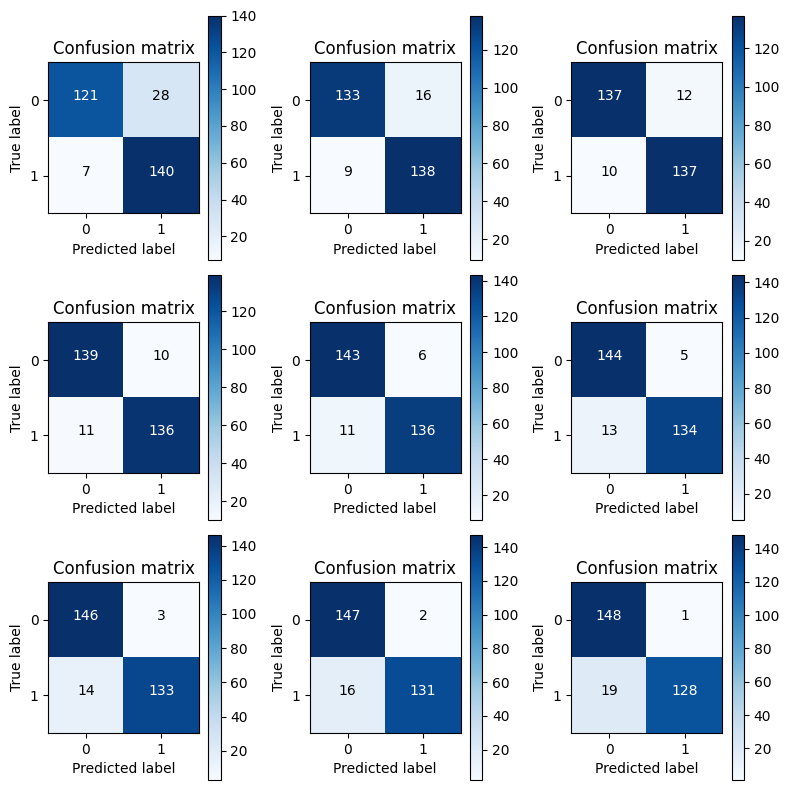

In [14]:
#using undersampling test data
best_thresh(X_train_undersample, y_train_undersample, X_test_undersample, y_test_undersample, best_c_under)

thresholds:  0.1 Recall: 0.97 Accuracy: 0.009
thresholds:  0.2 Recall: 0.95 Accuracy: 0.015
thresholds:  0.3 Recall: 0.95 Accuracy: 0.021
thresholds:  0.4 Recall: 0.94 Accuracy: 0.027
thresholds:  0.5 Recall: 0.93 Accuracy: 0.034
thresholds:  0.6 Recall: 0.90 Accuracy: 0.042
thresholds:  0.7 Recall: 0.90 Accuracy: 0.054
thresholds:  0.8 Recall: 0.89 Accuracy: 0.069
thresholds:  0.9 Recall: 0.88 Accuracy: 0.097


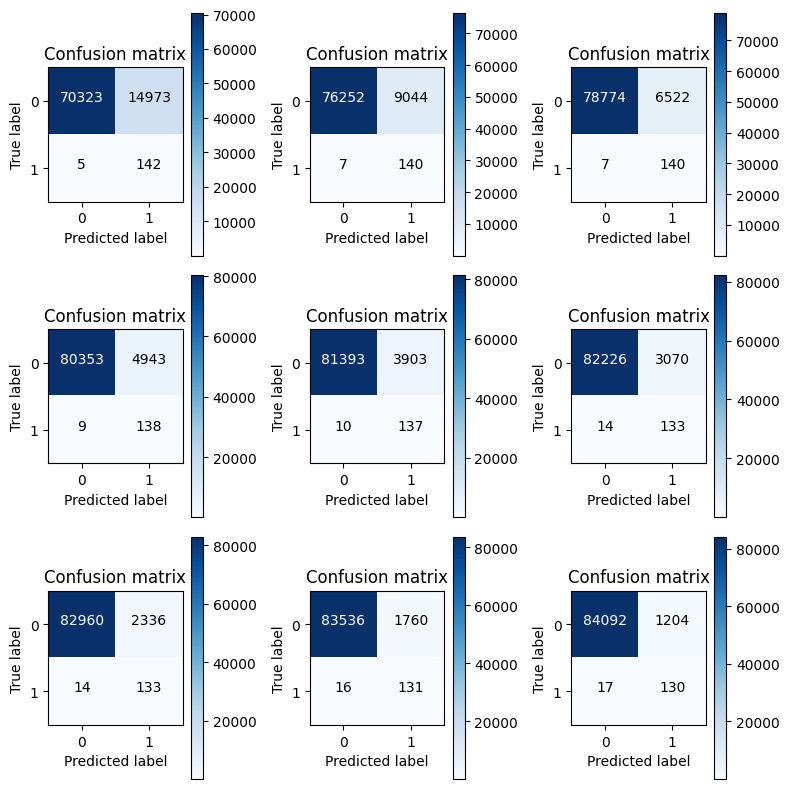

In [15]:
#using original test data
best_thresh(X_train_undersample, y_train_undersample, X_test, y_test, best_c_under)

### Oversampling(SMOTE )


In [16]:
from imblearn.over_sampling import SMOTE

In [17]:
# copy data
credit_cards = data.copy()
columns = credit_cards.columns
features_columns = columns.delete(len(columns)-1)  # feature column

X_oversample = credit_cards[features_columns]          # features
y_oversample = credit_cards['Class']                     # labels

In [18]:
# divide features and labels to train and test
X_train_oversample, X_test_oversample, y_train_oversample, y_test_oversample\
 = train_test_split(X_oversample, y_oversample, test_size = 0.3, random_state = 0)

In [19]:
oversampler=SMOTE(random_state=0)
#Creating New data using SMOTE
X_train_oversample_sm, y_train_oversample_sm =oversampler.fit_resample(X_train_oversample, y_train_oversample)

0    199019
1    199019
Name: Class, dtype: int64


Text(0, 0.5, 'Frequency')

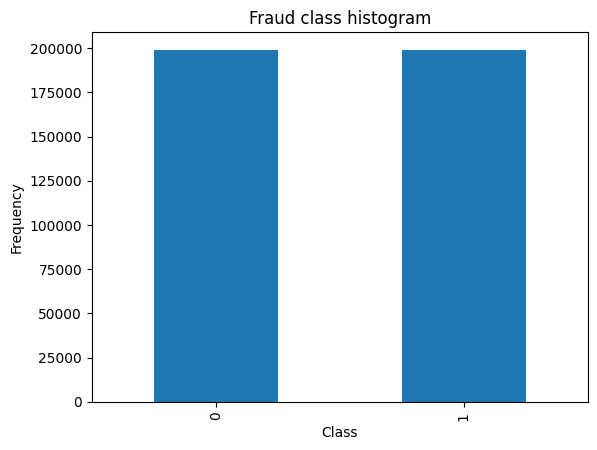

In [20]:
# plot number of data
os_count_classes = pd.value_counts(y_train_oversample_sm, sort = True).sort_index() # the numbers of 0 and 1
print(os_count_classes)
os_count_classes.plot(kind = "bar")
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [21]:
# transfor smote creating data to dataframe
X_train_oversample_sm = pd.DataFrame(X_train_oversample_sm)
y_train_oversample_sm = pd.DataFrame(y_train_oversample_sm)

In [22]:
best_c_over = kfold_regularization(X_train_oversample_sm, y_train_oversample_sm)

C parameter: 0.01
--------------------
Average Accuracy: 0.9998492607180285
Average Recall: 1.0

C parameter: 0.1
--------------------
Average Accuracy: 0.9999799014858766
Average Recall: 1.0

C parameter: 1
--------------------
Average Accuracy: 1.0
Average Recall: 1.0

C parameter: 10
--------------------
Average Accuracy: 1.0
Average Recall: 1.0

C parameter: 100
--------------------
Average Accuracy: 1.0
Average Recall: 1.0

C parameter: 1000
--------------------
Average Accuracy: 1.0
Average Recall: 1.0

C parameter: 10000
--------------------
Average Accuracy: 1.0
Average Recall: 1.0

C parameter: 100000
--------------------
Average Accuracy: 1.0
Average Recall: 1.0

    c_params Mean recall score
0       0.01               1.0
1       0.10               1.0
2       1.00               1.0
3      10.00               1.0
4     100.00               1.0
5    1000.00               1.0
6   10000.00               1.0
7  100000.00               1.0
best c parameters  =  0.01


thresholds:  0.1 Recall: 1.00 Accuracy: 0.762
thresholds:  0.2 Recall: 1.00 Accuracy: 0.870
thresholds:  0.3 Recall: 1.00 Accuracy: 0.891
thresholds:  0.4 Recall: 1.00 Accuracy: 0.896
thresholds:  0.5 Recall: 1.00 Accuracy: 0.896
thresholds:  0.6 Recall: 1.00 Accuracy: 0.913
thresholds:  0.7 Recall: 1.00 Accuracy: 0.930
thresholds:  0.8 Recall: 1.00 Accuracy: 0.930
thresholds:  0.9 Recall: 1.00 Accuracy: 0.942


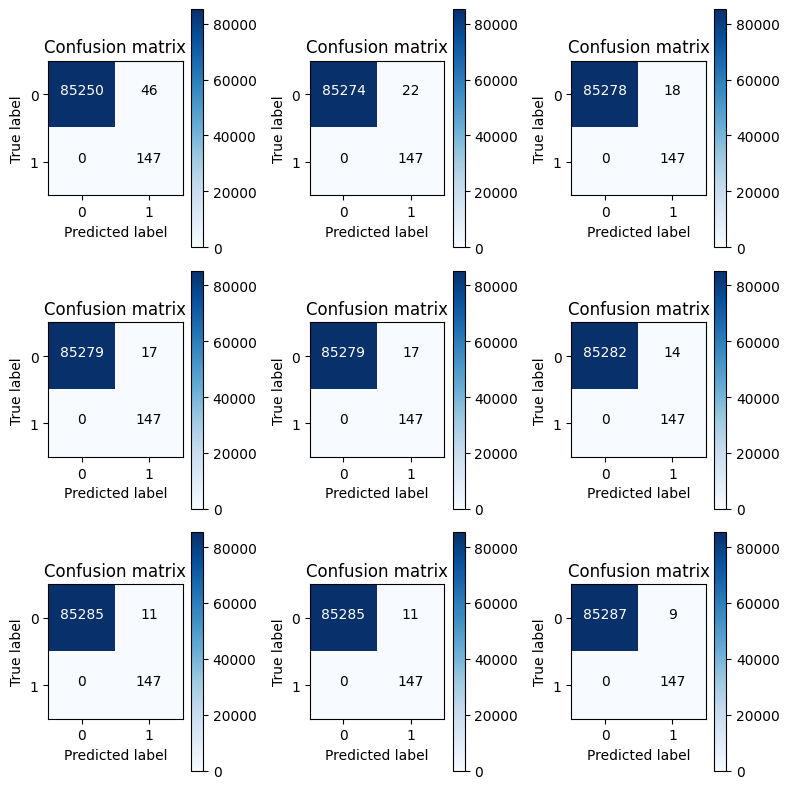

In [23]:
#using original test data, copied from data
best_thresh(X_train_oversample_sm, y_train_oversample_sm, X_test_oversample, y_test_oversample, best_c_over)